In [1]:
import numpy as np

In [2]:
from definitions import path_join, make_directory, EXPERIMENTS_DIR, VENSIM_MODELS_DIR, logging

In [3]:
KNOWN_MODEL = 'known model'
UNKNOWN_MODEL = 'unknown model'

In [4]:
model_name = 'predator_prey'
experiment_name = '{}_find_coefficients_2000'.format(model_name)

mode = KNOWN_MODEL
need_retrain = False

In [5]:
import tensorflow as tf

general_params = {
    'phi_h': tf.keras.activations.linear,
    'phi_o': tf.keras.activations.linear,
}

train_params = {
    'learning_rate': 1e-1,
    'epochs_before_decay': 100,
    'epochs_count': 50,
    'learning_rate_decay': 0.9,
    'iterations_count': 300,
    'early_stopping_patience': 10,
}

In [6]:
def create_experiment_enviroment(model_name, experiment_name, mode):
    experiment_settings = dict()
    
    experiment_settings['model_name'] = model_name
    experiment_settings['experiment_name'] = experiment_name
    experiment_settings['mode'] = mode
    
    experiment_dir = path_join(EXPERIMENTS_DIR, experiment_name)
    make_directory(experiment_dir)
    experiment_settings['experiment_dir'] = experiment_dir
    
    tf_model_dir = path_join(experiment_dir, 'tf_model')
    make_directory(tf_model_dir)
    experiment_settings['tf_model_dir'] = tf_model_dir
    
    images_dir = path_join(experiment_dir, 'images')
    make_directory(images_dir)
    experiment_settings['images_dir'] = images_dir
    
    log_path = path_join(experiment_dir, 'log.log')
    logging.basicConfig(filename=log_path, level=logging.INFO)
    experiment_settings['log_path'] = log_path

    vensim_model_file = path_join(VENSIM_MODELS_DIR, '{}.mdl'.format(model_name))
    experiment_settings['vensim_model_file'] = vensim_model_file
    
    prn_model_dir = path_join(tf_model_dir, 'prn_model')
    nn_model_dir = path_join(tf_model_dir, 'base_nn_model')
    make_directory(prn_model_dir)
    make_directory(nn_model_dir)
    experiment_settings['prn_model_dir'] = prn_model_dir
    experiment_settings['nn_model_dir'] = nn_model_dir

    return experiment_settings
    
experiment_settings = create_experiment_enviroment(model_name, experiment_name, mode)

In [7]:
experiment_settings['vensim_model_file']

'C:\\Users\\HWer\\Documents\\GitHub\\SDtoPRN\\vensim_models\\predator_prey.mdl'

In [8]:
from definitions import path_join, DATA_DIR

dataset_dir = path_join(DATA_DIR, model_name)
dataset_file = path_join(dataset_dir, 'dataset_2000.csv')

In [9]:
from module.fd_model.vensim_fd_converter import create_known_model

FD = create_known_model(experiment_settings['vensim_model_file'])

In [10]:
import pandas as pd

data = pd.read_csv(dataset_file)
data.head(10)

,sim_index,Predator Population,Prey Population,predator birth fraction,predator death proportionality constant,prey birth fraction,prey death proportionality constant
0,0,25.000000,50.000000,0.025,1.06,1.25,0.015
1,0,25.148438,51.367188,0.025,1.06,1.25,0.015
2,0,25.324618,52.768185,0.025,1.06,1.25,0.015
3,0,25.529751,54.203036,0.025,1.06,1.25,0.015
4,0,25.765164,55.671690,0.025,1.06,1.25,0.015
5,0,26.032310,57.173995,0.025,1.06,1.25,0.015
6,0,26.332780,58.709680,0.025,1.06,1.25,0.015
7,0,26.668310,60.278345,0.025,1.06,1.25,0.015
8,0,27.040799,61.879442,0.025,1.06,1.25,0.015
9,0,27.452314,63.512262,0.025,1.06,1.25,0.015


In [11]:
fields = [level for level in FD.names_units_map.keys()]
fields

['Predator Population',
 'Prey Population',
 'predator birth fraction',
 'predator death proportionality constant',
 'prey birth fraction',
 'prey death proportionality constant']

In [12]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler((0.001, 1))
# scaler.fit(data[fields])
# data[fields] = scaler.transform(data[fields])

In [13]:
from sklearn.model_selection import train_test_split


def np_preproc_for_rnn3d(numpy_array, fields):
    x_groups = [group[1][fields].values[:-1] for group in numpy_array]
    y_groups = [group[1][fields].values[1:] for group in numpy_array]
    
    train_X, valid_X, train_y, valid_y = train_test_split(x_groups, y_groups, test_size=0.2, random_state=123)
    
    train_X = np.concatenate(train_X, axis=0)
    valid_X = np.concatenate(valid_X, axis=0)
    
    train_y = np.concatenate(train_y, axis=0)
    valid_y = np.concatenate(valid_y, axis=0)

    return (train_X, train_y), (valid_X, valid_y)


def generate_train_data(df, fields):
    dataset = df[fields].values
    grouped = df.groupby(['sim_index'])[fields]
    
    return dataset, np_preproc_for_rnn3d(grouped, fields)

In [14]:
_, (prn_train, prn_valid) = generate_train_data(data, fields)

In [15]:
prn_train_X, prn_train_y = prn_train
prn_valid_X, prn_valid_y = prn_valid

In [16]:
prn_valid_X.shape

(120000, 6)

In [17]:
import tensorflow as tf
from tensorflow.python.framework import ops

ops.reset_default_graph()

In [18]:
from module.fd_model.fd_rnn_converter import FDRNNConverter
from module.nn_model_tf_v2 import NNModel as NNModelv2
from module.nn_model_tf_v3 import NNModel as NNModelv3
from module.nn_model_tf_v21 import NNModel as NNModelv21

choosed_model = NNModelv2

In [19]:
FDRNN_converter = FDRNNConverter(general_params['phi_h'], general_params['phi_o'])
rnn_model = FDRNN_converter.fd_to_rnn(FD, choosed_model)

In [20]:
FD.levels
# FD.constants
# FD.rates
FD.dT

0.03125

In [21]:
fields

['Predator Population',
 'Prey Population',
 'predator birth fraction',
 'predator death proportionality constant',
 'prey birth fraction',
 'prey death proportionality constant']

In [22]:
# rnn_model.model.gate = gate
# rnn_model.model.W_ah = W

In [23]:
if need_retrain:
    rnn_model.train(prn_train_X, prn_train_y, (prn_valid_X, prn_valid_y), train_params, experiment_settings['prn_model_dir'])

In [24]:
rnn_model.load(experiment_settings['prn_model_dir'])

In [25]:
# tf.round(rnn_model.model.gate)
# tf.round(rnn_model.model.W_ah)
# rnn_model.model.W_xy
# rnn_model.model.W_xy

In [26]:
rnn_model.model.gate

<tf.Variable 'Variable:0' shape=(6, 4) dtype=float32, numpy=
array([[-0.54611146, -0.4889502 ,  1.0489897 ,  0.00250586],
       [-0.03462083,  0.9936567 , -0.4815463 , -0.50194484],
       [-0.5337537 ,  0.9942288 ,  0.99988   ,  0.9917477 ],
       [ 0.9870347 , -1.036548  ,  1.009165  ,  1.004189  ],
       [ 0.99920315,  0.9980368 , -0.5761102 ,  0.99845445],
       [ 1.003768  ,  1.0032344 ,  1.0063292 , -0.49127093]],
      dtype=float32)>

In [27]:
tf.round(rnn_model.model.gate)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[-1.,  0.,  1.,  0.],
       [ 0.,  1.,  0., -1.],
       [-1.,  1.,  1.,  1.],
       [ 1., -1.,  1.,  1.],
       [ 1.,  1., -1.,  1.],
       [ 1.,  1.,  1.,  0.]], dtype=float32)>

In [28]:
tf.round(tf.sigmoid(rnn_model.model.gate))

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0., 0., 1., 1.],
       [0., 1., 0., 0.],
       [0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]], dtype=float32)>

In [29]:
tf.round(rnn_model.model.W_ah)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [30]:
def parse_weights(gate, w, fields):
    equations = []
    for col_idx in range(gate.shape[1]):
        equation = ''
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 0:
                sign = '*' if w[row_idx, col_idx] > 0 else '/'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 1:
                sign = '+' if w[row_idx, col_idx] > 0 else '-'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])

        equations.append(equation)
    return equations

In [31]:
_gate = np.array(tf.round(tf.sigmoid(rnn_model.model.gate)), dtype=np.int32)
_w = np.array(tf.round(rnn_model.model.W_ah), dtype=np.int32)
# print(fields)
parse_weights(_gate, _w, fields)

['*Predator Population*Prey Population*predator birth fraction',
 '*Predator Population',
 '*Prey Population*prey birth fraction',
 '*Prey Population*prey death proportionality constant+Predator Population']

In [34]:
rnn_model.model.gate

<tf.Variable 'Variable:0' shape=(6, 4) dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [35]:
tf.round(rnn_model.model.gate)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [36]:
rnn_model.model.W_ah

<tf.Variable 'Variable:0' shape=(6, 4) dtype=float32, numpy=
array([[1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [37]:
tf.round(rnn_model.model.W_ah)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [38]:
rnn_model.model.W_xy

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [39]:
rnn_model.model.W_ry

<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
array([[ 0.03125,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [-0.03125,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.03125,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , -0.03125,  0.     ,  0.     ,  0.     ,  0.     ]],
      dtype=float32)>

In [40]:
def get_weights(rnn_model, model_dir, FDRNN_converter):
    weights = rnn_model.get_weights(model_dir)
    w = weights['W']
    edges_list = FDRNN_converter.print_w(w)

    return w, edges_list

In [41]:
weight, edges_list = get_weights(rnn_model, prn_model_dir, FDRNN_converter)
weight, edges_list

NameError: name 'prn_model_dir' is not defined

<h3>Try simulation</h3>

In [32]:
initial_value = np.reshape(prn_valid_X[0], [1, prn_valid_X.shape[1]])
initial_value

array([[7.50e+01, 1.00e+02, 2.00e-02, 1.04e+00, 1.75e+00, 3.50e-02]])

In [33]:
iterations_count = train_params['iterations_count']
if iterations_count == 0:
    iterations_count = X.shape[0] - 1
iterations_count

300

In [34]:
prn_iterative = rnn_model.get_simulation(initial_value, iterations_count, experiment_settings['prn_model_dir'])

In [35]:
prn_iterative.shape

(301, 6)

In [36]:
prn_iterative[1:11]

array([[7.72634583e+01, 9.72650528e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [7.94621277e+01, 9.43638840e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [8.15782471e+01, 9.13221130e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [8.35946045e+01, 8.81668167e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [8.54949341e+01, 8.49259109e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [8.72642746e+01, 8.16274414e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [8.88893509e+01, 7.82989426e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [9.03588028e+01, 7.49668350e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 3.50000001e-02],
       [9.16634369e+01, 7.16558990e+01, 1.99999996e-02, 1.03999996e+00,
        1.75000000e+00, 

In [37]:
prn_valid_y[:10]

array([[7.72500000e+01, 9.72656250e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [7.94354810e+01, 9.43666534e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [8.15388656e+01, 9.13285136e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [8.35431171e+01, 8.81780786e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [8.54321355e+01, 8.49430203e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [8.71911309e+01, 8.16511471e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [8.88069541e+01, 7.83297581e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [9.02683701e+01, 7.50050432e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 3.50000000e-02],
       [9.15662624e+01, 7.17015564e+01, 2.00000000e-02, 1.04000000e+00,
        1.75000000e+00, 

In [50]:
rw_images_dir = 'C:/Users/HWer/Desktop/4_sem_final_omg_2/'
from definitions import *
make_directory(rw_images_dir)

<Figure size 432x288 with 0 Axes>

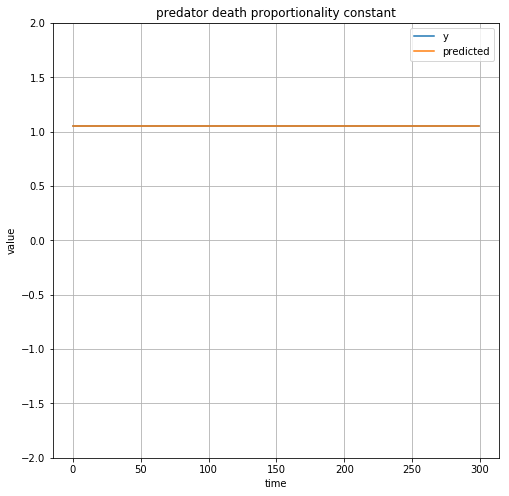

In [70]:
import matplotlib.pyplot as plt
plt.clf()

plt.figure(figsize=(8, 8))
column = 3

title = fields[column]
plt.title(title)
plt.xlabel('time')
plt.ylabel('value')
plt.plot(prn_valid_y[:iterations_count, column], label='y')
plt.plot(prn_iterative[1:, column], label='predicted')
# plt.plot(nn_iterative[:, column], label='nn')
plt.grid()
plt.legend()

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

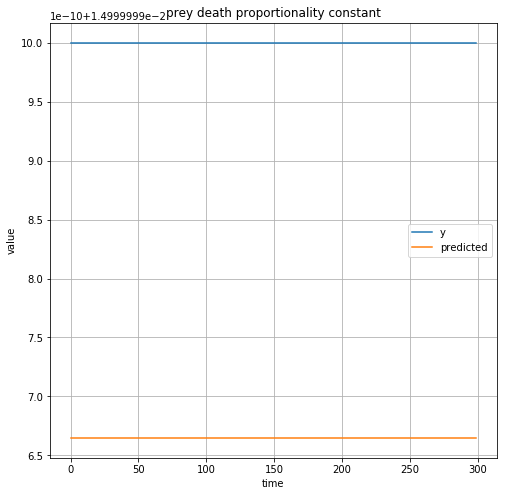

In [52]:
import matplotlib.pyplot as plt

for i in range(len(fields)):
    plt.clf()

    plt.figure(figsize=(8, 8))
    column = i

    title = fields[column]
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.plot(prn_valid_y[:iterations_count, column], label='y')
    plt.plot(prn_iterative[1:, column], label='predicted')
    # plt.plot(nn_iterative[:, column], label='nn')
    plt.grid()
    plt.legend()
#     plt.savefig(rw_images_dir + title + '.png')

In [60]:
def biplot(x, y, title, model_name, images_dir):
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y)
    plt.grid()

#     min_ylim = min(min(x), min(y))
#     max_ylim = max(max(x), max(y))

#     plt.ylim(min_ylim, max_ylim)

    plt.xlabel('y')
    plt.ylabel('predicted')
    plt.title(title)

    # plt.show()
    image_path = path_join(images_dir, title + '.png')
    plt.savefig(image_path)
#     plt.gcf().clear()

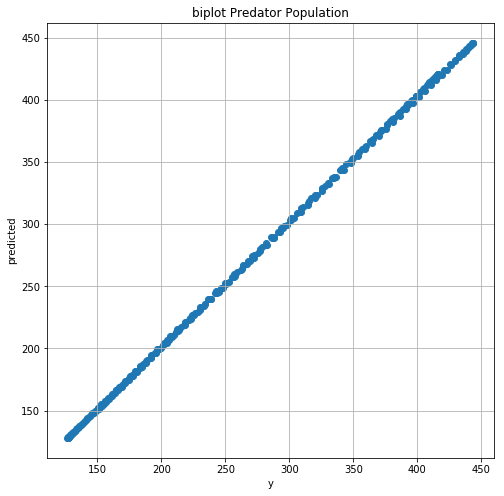

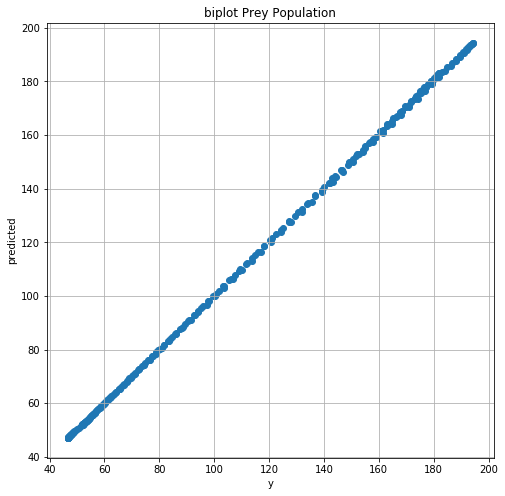

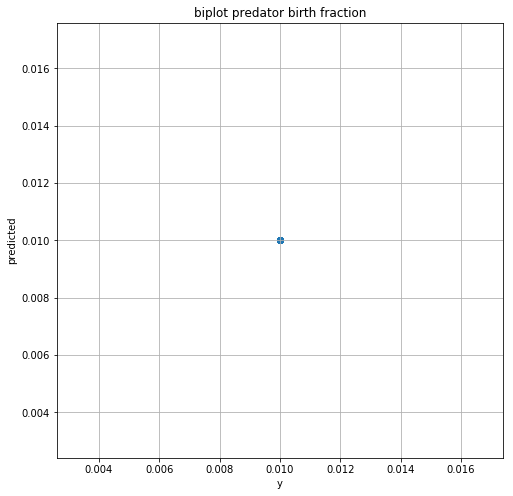

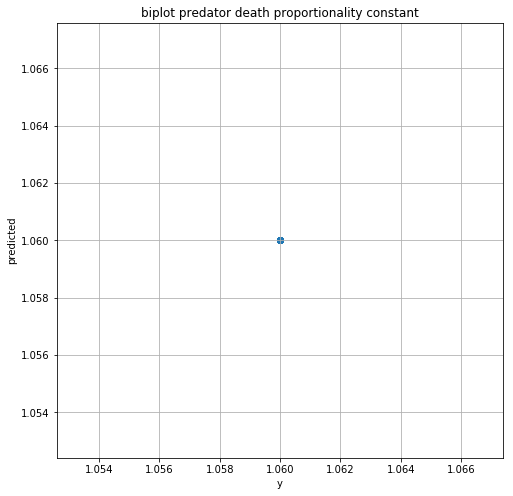

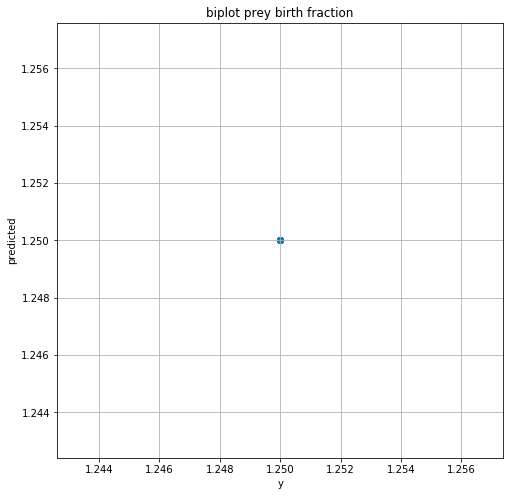

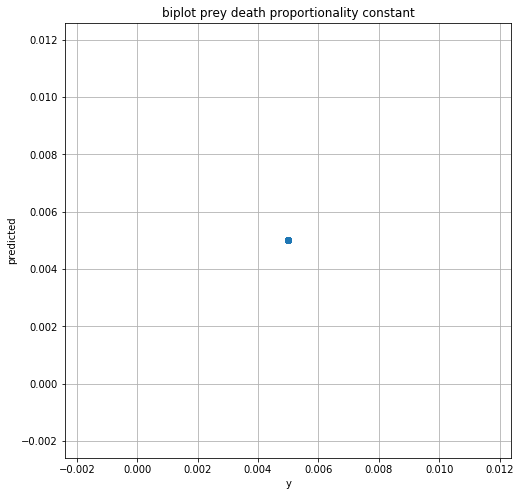

In [53]:
for level in fields:
    i = fields.index(level)
    level_output = prn_iterative[1:, i]
    level_y = prn_valid_y[:iterations_count, i]

    graphs = (level_output, level_y)
    labels = ('PRN_y', 'true_y')

    biplot_name2 = 'biplot {}'.format(level)
    biplot(level_output, level_y, biplot_name2, 'PRN', rw_images_dir)

In [85]:
prn_iterative[:50]

array([[1.50000000e+02, 1.40000000e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.51584076e+02, 1.42032471e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.53281097e+02, 1.44058533e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.55094116e+02, 1.46074463e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.57026245e+02, 1.48076309e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.59080612e+02, 1.50059860e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.61260422e+02, 1.52020706e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.63568863e+02, 1.53954178e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.66009125e+02, 1.55855392e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 

In [86]:
prn_test = rnn_model.test(prn_valid_X[:iterations_count], prn_model_dir)

In [87]:
prn_valid_X[:10]

array([[1.50000000e+02, 1.40000000e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.51593750e+02, 1.42187500e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.53308062e+02, 1.44373772e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.55146502e+02, 1.46554987e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.57112741e+02, 1.48727058e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.59210543e+02, 1.50885628e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.61443751e+02, 1.53026069e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.63816271e+02, 1.55143478e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.66332053e+02, 1.57232672e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 

In [88]:
prn_iterative[:10]

array([[1.50000000e+02, 1.40000000e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.51584076e+02, 1.42032471e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.53281097e+02, 1.44058533e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.55094116e+02, 1.46074463e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.57026245e+02, 1.48076309e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.59080612e+02, 1.50059860e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.61260422e+02, 1.52020706e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.63568863e+02, 1.53954178e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.66009125e+02, 1.55855392e+02, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 

In [89]:
prn_iterative[-5:]

array([[2.02374603e+02, 4.79726677e+01, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.98695969e+02, 4.82421227e+01, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.95100861e+02, 4.85423508e+01, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.91589035e+02, 4.88732338e+01, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03],
       [1.88160172e+02, 4.92346992e+01, 9.99999978e-03, 1.05999994e+00,
        1.25000000e+00, 4.99999989e-03]])

In [90]:
prn_iterative.shape

(301, 6)

In [91]:
prn_valid_y[:iterations_count]

array([[1.51593750e+02, 1.42187500e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.53308062e+02, 1.44373772e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.55146502e+02, 1.46554987e+02, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       ...,
       [2.03242108e+02, 4.88858290e+01, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.99614606e+02, 4.92429850e+01, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03],
       [1.96074128e+02, 4.96306611e+01, 1.00000000e-02, 1.06000000e+00,
        1.25000000e+00, 5.00000000e-03]])

In [23]:
from arch.base_nn import BaseNN
from arch.base_nn_2layers import BaseNN as BaseNN2Layers
from arch.lstm import LSTMModel

sequence_size = 5
nn_model_dir = experiment_settings['nn_model_dir'] + '_lstm_{}seq'.format(sequence_size)

predictor = LSTMModel((sequence_size, train_X.shape[1]), 32, train_X.shape[1])

NameError: name 'train_X' is not defined

In [24]:
from arch.base_nn import BaseNN

predictor = BaseNN(prn_train_X.shape[1], prn_train_X.shape[1])

In [25]:
predictor.train(prn_train_X, prn_train_y, (prn_valid_X, prn_valid_y), train_params, experiment_settings['nn_model_dir'])

Train on 480000 samples, validate on 120000 samples
Epoch 1/50
480000/480000 [==============================] - 31s 65us/sample - loss: 2018.8246 - mse: 2018.8199 - val_loss: 33.5239 - val_mse: 33.5239
Epoch 2/50
480000/480000 [==============================] - 31s 64us/sample - loss: 44.5727 - mse: 44.5726 - val_loss: 32.4556 - val_mse: 32.4556
Epoch 3/50
480000/480000 [==============================] - 32s 66us/sample - loss: 44.4807 - mse: 44.4806 - val_loss: 32.3299 - val_mse: 32.3300
Epoch 4/50
480000/480000 [==============================] - 33s 68us/sample - loss: 44.4388 - mse: 44.4390 - val_loss: 32.2424 - val_mse: 32.2424
Epoch 5/50
480000/480000 [==============================] - 31s 64us/sample - loss: 44.4002 - mse: 44.4002 - val_loss: 32.1166 - val_mse: 32.1166
Epoch 6/50
480000/480000 [==============================] - 29s 61us/sample - loss: 44.3086 - mse: 44.3085 - val_loss: 32.3164 - val_mse: 32.3163
Epoch 7/50
480000/480000 [==============================] - 29s 61us

In [ ]:
from sklearn.model_selection import train_test_split


def window_stack(a, stepsize=1, width=2):
    n = a.shape[1]
    omg = lambda i: 1+n+i-width
    _X = [a[:, i:i+width].astype(np.float16) for i in range(0, n - width)]
    _y = [a[:, i].astype(np.float16) for i in range(width, n)]
    del a
    _X = np.stack(_X, axis=1).astype(np.float16)
    _y = np.stack(_y, axis=1).astype(np.float16)

    return _X.reshape(-1, _X.shape[2], _X.shape[3]), _y.reshape(-1, _y.shape[2])

def get_X_y(data, width=7):
    data.fillna(0, inplace=True)
    
    X = np.array(list(data.groupby('sim_index').apply(pd.DataFrame.as_matrix)))
    X, y = window_stack(X, width=width)
    X = X[:, :, 1:]
    y = y[:, 1:]
    
    return X, y

train_ids, valid_ids = train_test_split(data['sim_index'].unique(), test_size=0.2, random_state=123)
rnn_train = data[data['sim_index'].isin(train_ids)]
rnn_train_X, rnn_train_y = get_X_y(rnn_train, sequence_size)

In [ ]:
rnn_train_X[0]

In [ ]:
rnn_valid = data[data['sim_index'].isin(valid_ids)]
rnn_valid_X, rnn_valid_y = get_X_y(rnn_valid, sequence_size)
rnn_valid_X[0]

In [38]:
if need_train:
    predictor.train(rnn_train_X, rnn_train_y, (rnn_valid_X, rnn_valid_y), train_params, nn_model_dir)

In [39]:
nn_model_dir

'C:\\Users\\HWer\\Documents\\GitHub\\SDtoPRN\\experiments\\predator_prey_modeling\\tf_model\\base_nn_model_lstm_5seq'

In [43]:
rnn_initial_value = np.reshape(rnn_valid_X[0], [1, rnn_valid_X.shape[1], rnn_valid_X.shape[2]])
nn_iterative = predictor.get_simulation(rnn_initial_value, iterations_count-sequence_size, nn_model_dir)

In [44]:
nn_iterative[:10]

array([[1.60000000e+02, 1.30000000e+02, 4.00085449e-02, 1.05957031e+00,
        1.25000000e+00, 4.00085449e-02],
       [1.84000000e+02, 1.12312500e+02, 4.00085449e-02, 1.05957031e+00,
        1.25000000e+00, 4.00085449e-02],
       [2.06875000e+02, 9.41250000e+01, 4.00085449e-02, 1.05957031e+00,
        1.25000000e+00, 4.00085449e-02],
       [2.27500000e+02, 7.65000000e+01, 4.00085449e-02, 1.05957031e+00,
        1.25000000e+00, 4.00085449e-02],
       [2.44375000e+02, 6.04375000e+01, 4.00085449e-02, 1.05957031e+00,
        1.25000000e+00, 4.00085449e-02],
       [2.44132645e+02, 5.66390076e+01, 2.88518667e-02, 1.04634547e+00,
        1.24797475e+00, 2.88309418e-02],
       [2.30731140e+02, 6.33535347e+01, 2.32526511e-02, 1.04587698e+00,
        1.24767256e+00, 2.54100002e-02],
       [2.18716064e+02, 6.68700256e+01, 2.02383101e-02, 1.04629052e+00,
        1.24767435e+00, 2.33081542e-02],
       [2.21622757e+02, 5.73811951e+01, 1.66765898e-02, 1.05060029e+00,
        1.24791241e+00, 

In [45]:
nn_iterative.shape

(300, 6)

In [46]:
nn_test = predictor.test(rnn_valid_X[:iterations_count], nn_model_dir)

In [47]:
predictor.calculate_trainable_parameters()

5190

<h3>Train set error</h3>

In [38]:
def calculate_error(required_columns_data, output):
    output = np.array(output)
    error = sum(abs((output-required_columns_data)/required_columns_data))/required_columns_data.shape[0]

    return error

In [42]:
initial_value = np.reshape(prn_train_X[0], [1, prn_train_X.shape[1]])
iterations_count = prn_train_X.shape[0]-1
train_prn_output = rnn_model.test(prn_train_X, experiment_settings['prn_model_dir'])

In [43]:
train_prn_error = calculate_error(prn_train_y, train_prn_output)
train_prn_error

array([5.55914397e-04, 4.09208858e-02, 1.84654657e-08, 3.41984082e-08,
       0.00000000e+00, 1.85033838e-08])

In [44]:
train_nn_output = predictor.test(train_X, experiment_settings['nn_model_dir'])
train_nn_error = calculate_error(prn_train_y, train_nn_output)
train_nn_error

NameError: name 'predictor' is not defined

<h3>Test set error</h3>

In [41]:
prn_error = calculate_error(valid_y, prn_output)
prn_error

ValueError: operands could not be broadcast together with shapes (240,3) (48,3) 

In [ ]:
nn_error = calculate_error(valid_y, nn_output)
nn_error

In [54]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [55]:
notebook.display(port=6006, height=1000)

PRN loss history

In [56]:
import pickle

file_name = path_join(prn_model_dir, 'loss_history')
print(file_name)
with open(file_name, 'rb') as file:
    prn_train_data = pickle.load(file)

print(prn_train_data.keys())

# file_name = path_join(nn_model_dir, 'loss_history')
# print(file_name)
# with open(file_name, 'rb') as file:
#     nn_train_data = pickle.load(file)

# print(nn_train_data.keys())

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\predator_prey_modeling_new_prn\tf_model\prn_model\loss_history
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [57]:
import os

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


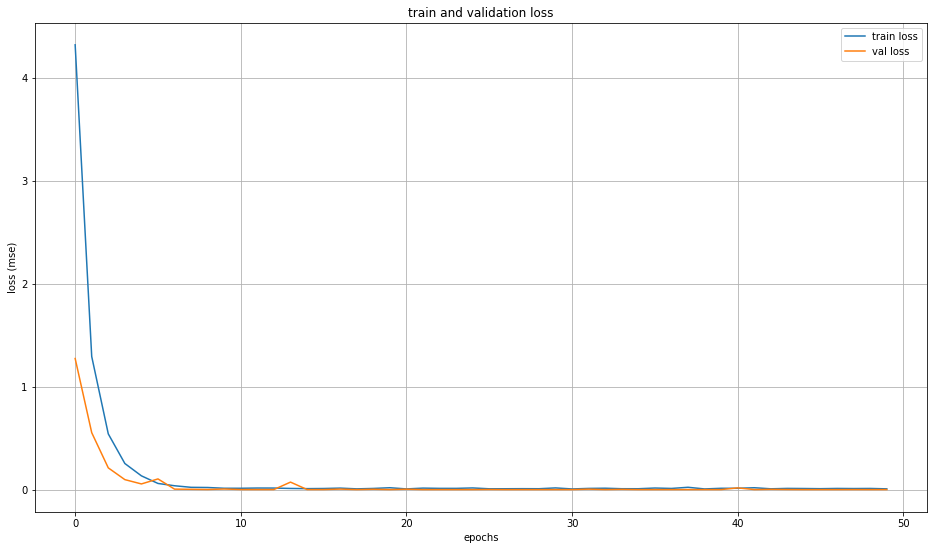

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(prn_train_data['loss'], label='train loss')
plt.plot(prn_train_data['val_loss'], label='val loss')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
# plt.title('PRN and NN train loss')
# plt.ylim(0, 0.5)
y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)
# plt.yticks(y_ticks)
title = 'train and validation loss'
plt.title(title)
# plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(rw_images_dir, title))

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


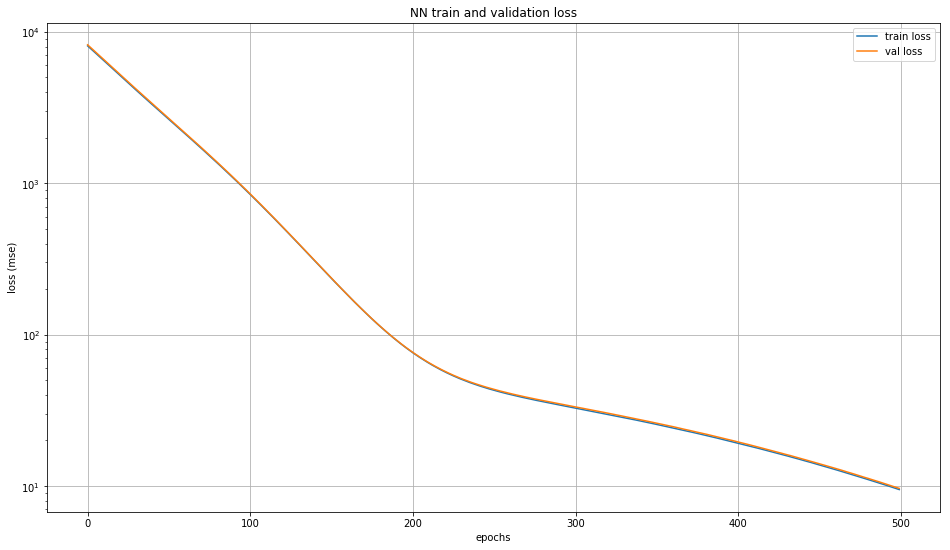

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(nn_train_data['loss'], label='train loss')
plt.plot(nn_train_data['val_loss'], label='val loss')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
# plt.title('PRN and NN train loss')
# plt.ylim(0, 0.5)
y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)
# plt.yticks(y_ticks)
title = 'NN train and validation loss'
plt.title(title)
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(images_dir, title))

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(prn_train_data['loss'], label='PRN')
plt.plot(nn_train_data['loss'], label='NN')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.title('PRN and NN train loss')
# plt.ylim(0, 0.5)
y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)
# plt.yticks(y_ticks)
title = 'PRN and NN train loss'
plt.title(title)
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(images_dir, title))

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


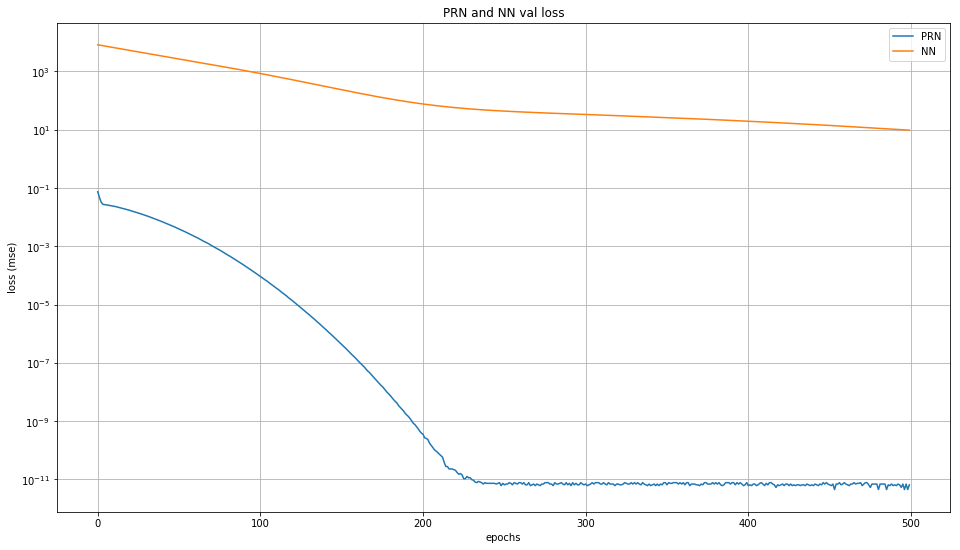

In [44]:
plt.figure(figsize=(16, 9))

plt.plot(prn_train_data['val_loss'], label='PRN')
plt.plot(nn_train_data['val_loss'], label='NN')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.title('PRN and NN val loss')
# plt.ylim(0, 0.5)
y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)
# plt.yticks(y_ticks)
title = 'PRN and NN val loss'
plt.title(title)
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(images_dir, title))

In [55]:
def biplot(x, y, title, model_name, images_dir):
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y)
    plt.grid()

#     min_ylim = min(min(x), min(y))
#     max_ylim = max(max(x), max(y))

#     plt.ylim(min_ylim, max_ylim)

    plt.xlabel('y')
    plt.ylabel('predicted')
    plt.title(title)

    # plt.show()
    image_path = path_join(images_dir, title + '.png')
    plt.savefig(image_path)
#     plt.gcf().clear()

In [56]:
def plot_graphs(graphs, labels, field_name, model_name, images_dir):
    for graph, label in zip(graphs, labels):
        line_style = '-'
        if label != 'true_y':
            line_style = '--'
        plt.plot(graph, linestyle=line_style, label=label)

    # min_ylim = min(y2) # for big values bug
    # max_ylim = max(y2)
    # plt.ylim(min_ylim, max_ylim)
    plt.xlabel('Time')
    plt.ylabel('{} value'.format(field_name))
    plt.grid()
    plt.legend()
    title = '{} modeling with {}'.format(field_name, model_name)
    plt.title(title)

    image_path = path_join(images_dir, title + '.png')
    plt.savefig(image_path)
    plt.gcf().clear()


In [58]:
for level in fields:
    i = fields.index(level)
    level_output = prn_iterative[1:iterations_count, i]
#     level_nn_output = nn_output[:, i]
    level_y = simulation_data[:iterations_count, i]

    graphs = (level_output, level_nn_output, level_y)
    labels = ('PRN_y', 'NN_y', 'true_y')

#     biplot_name1 = 'biplot {} NN and SD simulation'.format(level)
#     biplot(level_nn_output, level_y, biplot_name1, 'NN', images_dir)
    
#     biplot_name2 = 'biplot {} PRN and SD simulation'.format(level)
#     biplot(level_output, level_y, biplot_name2, 'PRN', images_dir)
#     graph_name = 'graph {} SD and PRN graphs'.format(level)
    biplot_name2 = 'biplot {}'.format(level)
    biplot(level_output, level_y, biplot_name2, 'PRN', rw_images_dir)

    

#     plot_graphs(graphs, labels, '{} ({})'.format(model_name, level), images_dir)

NameError: name 'nn_output' is not defined

In [52]:
for level in fields:
    i = fields.index(level)
    level_output = prn_output[:, i]
    level_nn_output = nn_output[:, i]
    level_y = simulation_data[:, i]

    graphs = (level_output, level_y)
    labels = ('PRN_y', 'true_y')
#     graphs = (level_output, level_nn_output, level_y)
#     labels = ('PRN_y', 'NN_y', 'true_y')
#     biplot_name1 = 'biplot {} NN and SD simulation'.format(level)
#     biplot(level_nn_output, level_y, biplot_name1, 'NN', images_dir)
    
#     biplot_name2 = 'biplot {} PRN and SD simulation'.format(level)
#     biplot(level_output, level_y, biplot_name2, 'PRN', images_dir)
#     graph_name = 'graph {} SD and PRN graphs'.format(level)

    

    plot_graphs(graphs, labels, level, 'PRN', images_dir)

<Figure size 432x288 with 0 Axes>